In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from pytorchtools import EarlyStopping
# # 设置中文和负号正常显示
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
scaler = MinMaxScaler(feature_range=(0, 1))

### 导入数据

In [3]:
df = pd.read_excel(r"F:\实验室\电网项目\服务器性能数据.xlsx", index_col=0)
df2 = df.copy(deep=True) 

In [4]:
# Draw Plot-----绘图函数
def plot_df(df, x, y, title="", xlabel='Index', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

### 缺失值填充

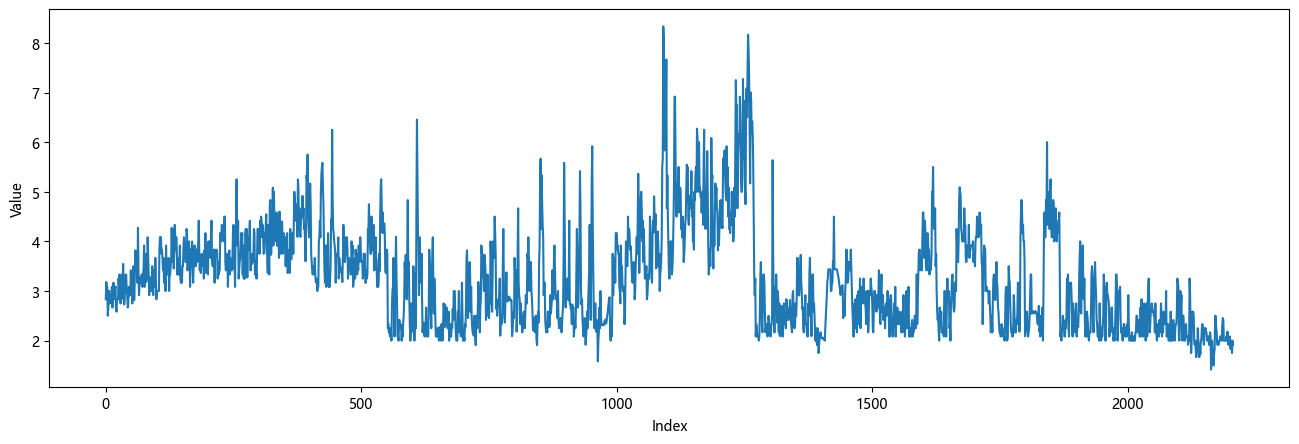

In [5]:
# k近邻法
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts) + 1, int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out
# 使用k-近邻法填补缺失值
df2["主机CPU平均负载"] = knn_mean(df2["主机CPU平均负载"], 24)
# df2["主机CPU平均负载"].astype(int)
plot_df(df2, x=df2.index, y= df2["主机CPU平均负载"], title='')

In [6]:
# 平滑前,滞后阶数
num_hour = 672
data_1 = df2["主机CPU平均负载"]
dataframe_1 = pd.DataFrame()
for i in range(num_hour-1,0,-1):
    dataframe_1['t-'+str(i)] = data_1.shift(i)
dataframe_1['t'] = data_1.values
for i in range(1,13):
    dataframe_1['t+'+str(i)] = data_1.shift(periods=-i, axis=0)

pd.set_option('display.max_columns', 16)
dataframe_1

,t-671,t-670,t-669,t-668,t-667,t-666,t-665,t-664,...,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.6667,3.0000,3.0000,2.7500,2.9167,2.9091,2.8333,3.0833
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0000,3.0000,2.7500,2.9167,2.9091,2.8333,3.0833,2.6667
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0000,2.7500,2.9167,2.9091,2.8333,3.0833,2.6667,2.9167
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.7500,2.9167,2.9091,2.8333,3.0833,2.6667,2.9167,3.1667
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.9167,2.9091,2.8333,3.0833,2.6667,2.9167,3.1667,2.8333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,2.8333,2.8333,2.0833,2.0833,2.0833,2.9167,2.8333,2.3333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2203,2.8333,2.0833,2.0833,2.0833,2.9167,2.8333,2.3333,2.1667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2204,2.0833,2.0833,2.0833,2.9167,2.8333,2.3333,2.1667,2.0833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2205,2.0833,2.0833,2.9167,2.8333,2.3333,2.1667,2.0833,2.0833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Loess Smoothing (5% and 15%)
# from statsmodels.nonparametric.smoothers_lowess import lowess
# plt.figure(figsize=(16,5), dpi=100)
# df_loess_5 = pd.DataFrame(lowess(df2["主机CPU平均负载"], np.arange(len(df2["主机CPU平均负载"])), frac=0.002)[:, 1], index=df2["主机CPU平均负载"].index, columns=['主机CPU平均负载'])
# plt.plot(df2["主机CPU平均负载"][100:200],label = '原始值', color = 'black')
# plt.plot(df_loess_5[100:200],label = '平滑曲线__frac=0.002',color = 'red')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.legend(loc='best')

In [8]:
# # 滞后阶数
# num_hour = 336
# data = df_loess_5["主机CPU平均负载"]
# dataframe = pd.DataFrame()
# for i in range(num_hour,0,-1):
#     dataframe['t-'+str(i)] = data.shift(i)
# dataframe['t'] = data.values
# dataframe

In [9]:
# all_data = dataframe_1[num_hour-1:-12]
# all_data

### 测试集和训练集

In [10]:
np.random.seed(2)
all_data = dataframe_1[num_hour-1:-12]
all_data = shuffle(all_data) 
all_data.to_csv('shuffle_smooth.csv')
pd.set_option('display.max_columns', 14)
# all_data = pd.read_csv(r"C:\Code\Python\PycharmProjects\数据分析\数据分析\shuffle.csv",index_col=0)
# all_data["groud_truth"] = dataframe_1["t"]
all_data

,t-671,t-670,t-669,t-668,t-667,t-666,t-665,...,t+6,t+7,t+8,t+9,t+10,t+11,t+12
1388,2.2727,2.1667,2.1818,2.1000,2.5000,2.5000,2.0833,...,2.166700,1.750000,1.909100,2.083300,2.083300,2.166700,2.061242
1406,3.9167,3.7500,3.7500,3.3333,3.2500,3.0000,3.7273,...,3.183340,3.258850,3.436157,3.436157,3.436157,3.436157,3.436157
814,3.3333,3.3333,3.9167,3.2500,3.1667,3.1818,3.1667,...,2.250000,2.545500,2.916700,2.750000,2.750000,3.750000,3.666700
1436,2.8333,2.5000,2.6667,2.7273,2.7500,2.9167,3.2500,...,3.117073,2.454500,2.750000,2.750000,2.500000,3.000000,3.166700
919,3.6667,4.2500,4.3333,3.4545,3.5833,3.0833,4.2500,...,2.750000,3.545500,4.166700,5.416700,4.666700,3.000000,2.727300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,4.0000,4.0909,3.5833,3.7273,3.9091,4.0833,4.0833,...,4.900000,4.666700,4.666700,5.416700,4.500000,4.833300,4.000000
970,4.1667,4.1667,3.7500,4.4167,4.2500,4.5000,4.4000,...,2.397186,2.397186,2.423157,2.339814,2.375529,2.482671,2.542200
1164,3.7500,3.4167,3.9167,3.5833,3.7273,4.0833,3.8333,...,5.583300,6.250000,4.666700,4.272700,4.250000,4.416700,5.181800
1198,3.6667,4.0833,3.6667,3.6364,3.0833,3.2500,3.0833,...,4.583300,4.272700,4.333300,4.272700,5.666700,5.416700,5.666700


In [11]:
# person = all_data.corr()
# indexSort = person.loc["t"].sort_values(ascending = False,inplace = False)
# index = indexSort[85:].index
# len(index)

In [12]:
# pd.set_option('display.max_columns', 13)
# person

In [13]:
# pd.set_option('display.max_columns', 14)
# for i in index:
#     del all_data[i]
# all_data

In [14]:
# all_data.iloc[0:var1,-12:]

In [15]:
var1 = int(len(all_data)*0.6)
var2 = int(len(all_data)*0.8)
train_data = all_data.iloc[0:var1]
train_truth = all_data.iloc[0:var1,-12:]
validate_data = all_data.iloc[var1:var2]
validate_truth = all_data.iloc[var1:var2,-12:]
test_data = all_data.iloc[var2:]
test_truth = all_data.iloc[var2:,-12:]
# train_data
# test_data
# validate_data

In [16]:
max_value = max(train_data.max().values)
min_value = min(train_data.min().values)
ch = max_value - min_value

### 归一化

In [17]:
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))
train_data_normalized = train_data_normalized.reshape(-1,num_hour+12)
train_data_normalized.shape

(914, 684)

In [18]:
validate_data_normalized = scaler.transform(validate_data.values.reshape(-1, 1))
validate_data_normalized = validate_data_normalized.reshape(-1,num_hour+12)
validate_data_normalized.shape

(305, 684)

In [19]:
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))
test_data_normalized = test_data_normalized.reshape(-1,num_hour+12)
test_data_normalized.shape

(305, 684)

In [20]:
train_X = torch.Tensor(train_data_normalized[:,0:-12].reshape(-1, 1, num_hour))
train_Y = torch.Tensor(train_data_normalized[:,-12:].reshape(-1, 1, 12))
train_Y.shape

torch.Size([914, 1, 12])

In [21]:
validate_X = torch.Tensor(validate_data_normalized[:,0:-12].reshape(-1, 1, num_hour))
validate_Y = torch.Tensor(validate_data_normalized[:,-12:].reshape(-1, 1, 12))
validate_X.shape

torch.Size([305, 1, 672])

In [22]:
test_X = torch.Tensor(test_data_normalized[:,0:-12].reshape(-1, 1, num_hour))
test_Y = torch.Tensor(test_data_normalized[:,-12:].reshape(-1, 1, 12))
test_Y.shape

torch.Size([305, 1, 12])

In [23]:
# train_data_temp = torch.utils.data.TensorDataset(train_X, train_Y)
# test_data_temp = torch.utils.data.TensorDataset(test_X, test_Y)
# train_data = DataLoader(train_data_temp, batch_size=256, shuffle=True, num_workers=1)#训练数据
# test_data = DataLoader(test_data_temp, batch_size=256, shuffle=False, num_workers=2)#测试数据

### 建立AE模型

In [24]:
start = time.time()

In [25]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        # [b, 336] => [b, 20]
        self.encoder = nn.Sequential(
            nn.Linear(672, 256),
            nn.ReLU(),
            nn.Linear(256, 84),
            nn.ReLU()
        )
        # [b, 20] => [b, 336]
        self.decoder = nn.Sequential(
            nn.Linear(84, 256),
            nn.ReLU(),
            nn.Linear(256, 672),
            nn.Sigmoid()
        )
    def forward(self, x):
        """
        :param x: [b, 1, 336]
        :return:
        """
        batchsz = x.size(0)
        # flatten
        x = x.view(batchsz, 672)
        # encoder
        x_en = self.encoder(x)
        # decoder
        x = self.decoder(x_en)
        # reshape
        x = x.view(batchsz, 1, 672)
        return x,x_en
    
model_AE = AE()
model_AE

AE(
  (encoder): Sequential(
    (0): Linear(in_features=672, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=84, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=84, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=672, bias=True)
    (3): Sigmoid()
  )
)

In [26]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_AE.parameters(), lr=1e-2)
epoch_n = 3000
# # 初始化 early_stopping 对象
# # 当验证集损失在连续20次训练周期中都没有得到降低时，停止模型训练，以防止模型过拟合
# patience = 100  

# # 关于 EarlyStopping 的代码可先看博客后面的内容
# early_stopping = EarlyStopping(patience, verbose=True)

In [27]:
# 开始训练
ep=[]
losses = []
lr_list = []
for e in range(1, epoch_n+1):
    var_x = Variable(train_X)
#     var_y = Variable(train_Y)
    # 前向传播
    out,out_hat = model_AE(var_x)
    loss = criterion(out, var_x)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 10 == 0: # 每 10 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e, loss.item()))
    ep.append(e)
    losses.append(loss.item())
    
#     valid_output,valid_output_hat = model_AE(validate_X)
#     valid_loss = criterion(valid_output, validate_X)
    
#     early_stopping(valid_loss, model_AE)
    
#     # 若满足 early stopping 要求
#     if early_stopping.early_stop:
#         print("Early stopping")
#         # 结束模型训练
#         break

print('Finished Training') 

Epoch: 10, Loss: 0.02561
Epoch: 20, Loss: 0.02466
Epoch: 30, Loss: 0.02363
Epoch: 40, Loss: 0.02193
Epoch: 50, Loss: 0.01627
Epoch: 60, Loss: 0.01546
Epoch: 70, Loss: 0.01414
Epoch: 80, Loss: 0.01360
Epoch: 90, Loss: 0.01323
Epoch: 100, Loss: 0.01291
Epoch: 110, Loss: 0.01308
Epoch: 120, Loss: 0.01222
Epoch: 130, Loss: 0.01187
Epoch: 140, Loss: 0.01143
Epoch: 150, Loss: 0.01097
Epoch: 160, Loss: 0.01129
Epoch: 170, Loss: 0.01048
Epoch: 180, Loss: 0.00976
Epoch: 190, Loss: 0.00932
Epoch: 200, Loss: 0.00905
Epoch: 210, Loss: 0.00888
Epoch: 220, Loss: 0.00888
Epoch: 230, Loss: 0.00852
Epoch: 240, Loss: 0.00834
Epoch: 250, Loss: 0.00821
Epoch: 260, Loss: 0.00803
Epoch: 270, Loss: 0.00795
Epoch: 280, Loss: 0.00787
Epoch: 290, Loss: 0.00771
Epoch: 300, Loss: 0.00747
Epoch: 310, Loss: 0.00787
Epoch: 320, Loss: 0.00740
Epoch: 330, Loss: 0.00723
Epoch: 340, Loss: 0.00720
Epoch: 350, Loss: 0.00712
Epoch: 360, Loss: 0.00701
Epoch: 370, Loss: 0.00715
Epoch: 380, Loss: 0.00690
Epoch: 390, Loss: 0.0

In [28]:
# plot_df(df, x=ep, y= losses, title='LOSS')

In [29]:
torch.save(model_AE, 'AE_net3.pkl')

D:\Softwore\python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type AE. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [30]:
model_AE2 = torch.load('AE_net3.pkl')

In [31]:
def rereal(list_temp, min_value, max_value):
    arr = []
    for dat in list_temp:
        temp = dat*(max_value-min_value) + min_value
        arr.append(temp)
    return arr

In [32]:
outputs, outputs_hat = model_AE2(train_X)
train_X2 = outputs_hat.reshape(-1,14,6)
train_X2.shape

torch.Size([914, 14, 6])

In [33]:
outputs, outputs_hat = model_AE2(validate_X)
validate_X2 = outputs_hat.reshape(-1,14,6)
validate_X2.shape

torch.Size([305, 14, 6])

In [34]:
outputs, outputs_hat = model_AE2(test_X)
test_X2 = outputs_hat.reshape(-1,14,6)
test_X2.shape

torch.Size([305, 14, 6])

### 建立LSTM模型

In [35]:
class lstm(nn.Module):
    def __init__(self,input_size=16,hidden_size=100,output_size=1,num_layer=2):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer,batch_first=True)
        self.layer2 = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        x,_ = self.layer1(x)
        x = x[:,[13],:]
        b, s, h = x.size()
        x = x.view(-1,h)
        x = self.layer2(x)
        x = x.view(b, s, -1)
        return x

model_lstm = lstm(6, 64, 12, 2)
model_lstm

lstm(
  (layer1): LSTM(6, 64, num_layers=2, batch_first=True)
  (layer2): Linear(in_features=64, out_features=12, bias=True)
)

In [36]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-2)
epoch_n = 1000
# 初始化 early_stopping 对象
# 当验证集损失在连续20次训练周期中都没有得到降低时，停止模型训练，以防止模型过拟合
patience = 40  

# 关于 EarlyStopping 的代码可先看博客后面的内容
early_stopping = EarlyStopping(patience, verbose=True)

In [37]:
# 开始训练
ep=[]
losses = []
lr_list = []
for e in range(1, epoch_n+1):
    var_x = Variable(train_X2)
    var_y = Variable(train_Y)
    # 前向传播
    out = model_lstm(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 10 == 0: # 每 10 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e, loss.item()))
    ep.append(e)
    losses.append(loss.item())
    
    valid_output = model_lstm(validate_X2)
    valid_loss = criterion(valid_output, validate_Y)
    
    early_stopping(valid_loss, model_lstm)
    
    # 若满足 early stopping 要求
    if early_stopping.early_stop:
        print("Early stopping")
        # 结束模型训练
        break
    
#     break
#     if (e+1)%120 == 0:
#         for p in optimizer.param_groups:
#             p['lr'] *= 0.1
#     lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

print('Finished Training') 

Validation loss decreased (inf --> 0.058699).  Saving model ...
Validation loss decreased (0.058699 --> 0.031204).  Saving model ...
EarlyStopping counter: 1 out of 40
Validation loss decreased (0.031204 --> 0.026436).  Saving model ...
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
Validation loss decreased (0.026436 --> 0.024773).  Saving model ...
Validation loss decreased (0.024773 --> 0.023030).  Saving model ...
EarlyStopping counter: 1 out of 40
Epoch: 10, Loss: 0.02489
EarlyStopping counter: 2 out of 40
Validation loss decreased (0.023030 --> 0.021860).  Saving model ...
Validation loss decreased (0.021860 --> 0.021004).  Saving model ...
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
Validation loss decreased (0.021004 --> 0.020887).  Saving model ...
Validation loss decreased (0.020887 --> 0.020404).  Saving model ...
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
Epoch: 20

EarlyStopping counter: 1 out of 40
Validation loss decreased (0.006272 --> 0.006210).  Saving model ...
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
Epoch: 150, Loss: 0.00527
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 9 out of 40
Validation loss decreased (0.006210 --> 0.006067).  Saving model ...
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
Epoch: 160, Loss: 0.00534
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStopping counter: 9 out of 40
EarlyStopping counter: 10 out of 40
EarlyStopping counter: 11 out of 40
EarlyStopping counter: 12 out of 40
EarlyStopping counter: 13 out of 40
E

EarlyStopping counter: 4 out of 40
Epoch: 330, Loss: 0.00219
EarlyStopping counter: 5 out of 40
Validation loss decreased (0.004401 --> 0.004252).  Saving model ...
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
Epoch: 340, Loss: 0.00206
EarlyStopping counter: 9 out of 40
EarlyStopping counter: 10 out of 40
EarlyStopping counter: 11 out of 40
EarlyStopping counter: 12 out of 40
Validation loss decreased (0.004252 --> 0.004189).  Saving model ...
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
Epoch: 350, Loss: 0.00198
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 8 out of 40
EarlyStoppi

In [38]:
end = time.time()

In [39]:
time = end - start
print(f'运行时长为:{int(time)}s')

运行时长为:371s


In [40]:
# plot_df(df, x=range(epoch_n), y= lr_list, title='LOSS')

In [41]:
# plot_df(df, x=ep, y= losses, title='LOSS')

In [42]:
torch.save(model_lstm, 'net3.pkl')

D:\Softwore\python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type lstm. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [43]:
model_lstm2 = torch.load('net3.pkl')

### 验证测试集

In [44]:
# def rereal(list_temp, min_value, max_value):
#     arr = []
#     for dat in list_temp:
#         temp = dat*(max_value-min_value) + min_value
#         arr.append(temp)
#     return arr

In [45]:
outputs = model_lstm2(test_X2)
loss = criterion(outputs, test_Y)
loss

tensor(0.0036, grad_fn=<MseLossBackward>)

In [46]:
# outputs.shape

In [47]:
# num = len(test_Y)

In [48]:
# outputs = outputs.reshape(num,12)
# y_pred_temp = outputs.detach().numpy()
# tru_temp = test_Y.detach().numpy().reshape(num)

In [49]:
def com_test(arr1,arr2):
    MSEs = []
    errors = []
    MAPEs = []
    num_temp = len(arr1)
    
    for i in range(num_temp):
        error = abs(arr1[i] - arr2[i])
        errors.append(error)
        MSEs.append(error**2)
        MAPEs.append((error/arr2[i])*100)
    
    MSE = np.mean(MSEs)
    MAPE = np.mean(MAPEs)
    
    return MSE, MAPE, MAPEs, errors

def mape(y_true, y_pred):
    """
    参数:
    y_true -- 测试集目标真实值
    y_pred -- 测试集目标预测值
    
    返回:
    mape -- MAPE 评价指标
    """
    y_true = y_true.reshape(-1).detach().numpy()
    y_pred = y_pred.reshape(-1).detach().numpy()
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred)/y_true))/n*100
    return mape

In [50]:
predict = outputs*(max_value-min_value) + min_value
truth =  torch.Tensor(test_truth.values.reshape(-1, 1, 12))

In [51]:
# predict[0][0]

In [52]:
print(f"测试集整体MSE: {criterion(predict, truth)}")

测试集整体MSE: 0.17252831161022186


In [53]:
print(f"测试集整体MAPE: {mape(truth, predict)}")

测试集整体MAPE: 10.053786707612595


In [54]:
order = 270
# 10,120,200,230,270

In [55]:
from scipy.stats import norm
from collections import deque
const = norm.ppf(1 - 0.01 / 2.)
samples_in = deque(test_data.iloc[order, -50-12:-12].values)
forecast = predict[order][0].detach().numpy().tolist()
# a = 总体平均值 - Z*标准误差
top = []
bottom = []
for i in range(12):
    samples_std = np.std(samples_in,ddof=1)
    a = forecast[i] - const * (samples_std / np.sqrt(50))* np.sqrt(i+1)
    b = forecast[i] + const * (samples_std / np.sqrt(50))* np.sqrt(i+1)
    top.append(b)
    bottom.append(a)
    
    samples_in.popleft()
    samples_in.append(forecast[i])

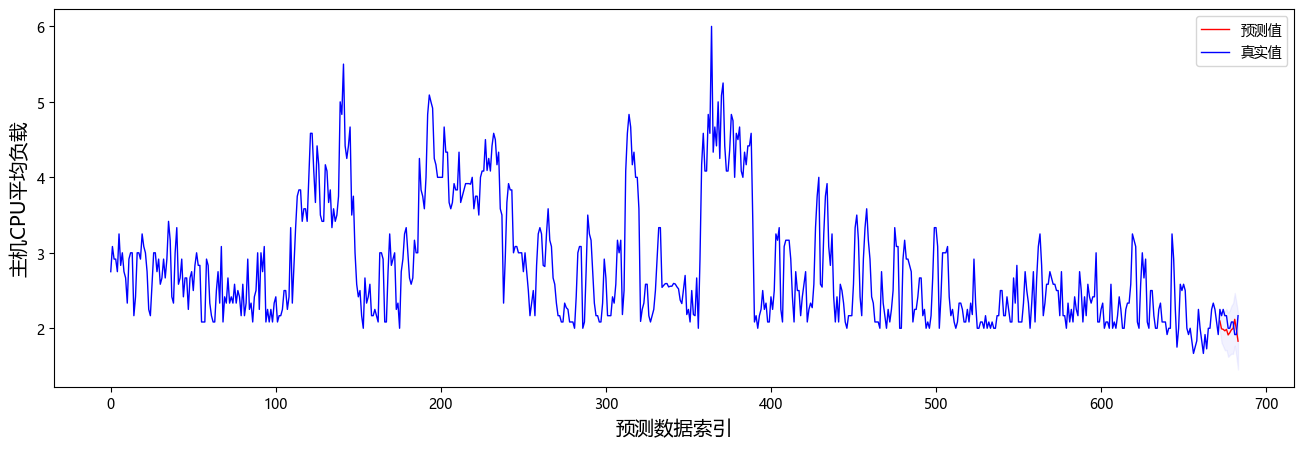

In [56]:
# 还原归一化
pre = predict[order][0].detach().numpy().tolist()
tru = test_data.iloc[order, :].values.tolist()
plt.figure(figsize=(16,5), dpi=100)
plt.xlabel(u"预测数据索引", fontsize=14)
plt.ylabel(u"主机CPU平均负载", fontsize=14)
plt.plot(range(672, 672+12), pre, c='red', lw='1',label="预测值")
plt.plot(range(672+12), tru, c='blue', lw='1',label="真实值")
plt.fill_between(range(672, 672+12),top,bottom,color='blue',alpha=0.05)
plt.legend(loc='best')

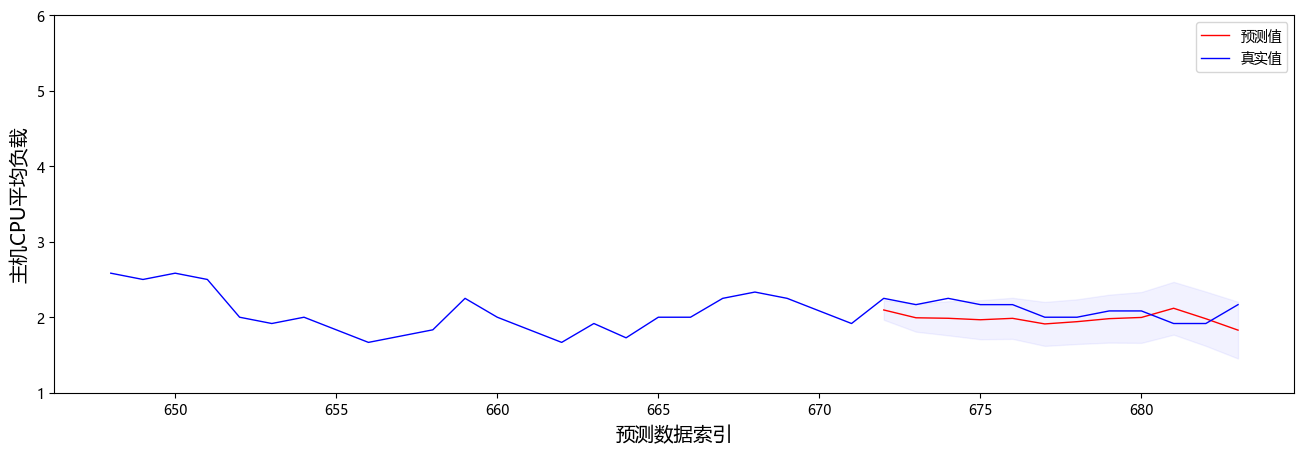

In [57]:
# 还原归一化
pre = predict[order][0].detach().numpy().tolist()
tru = test_data.iloc[order, :].values.tolist()
plt.figure(figsize=(16,5), dpi=100)
plt.xlabel(u"预测数据索引", fontsize=14)
plt.ylabel(u"主机CPU平均负载", fontsize=14)
plt.plot(range(672, 672+12), pre, c='red', lw='1',label="预测值")
plt.plot(range(672-24, 672+12), tru[-12-24:], c='blue', lw='1',label="真实值")
plt.ylim(1,6)
plt.fill_between(range(672, 672+12),top,bottom,color='blue',alpha=0.05)
plt.legend(loc='best')

In [58]:
MSE, MAPE, MAPEs, errors = com_test(pre, tru[-12:])
print(f"第一行MSE:   {round(MSE, 4)}\n第一行MAPE:  {round(MAPE, 2)}%")

第一行MSE:   0.0321
第一行MAPE:  7.51%


No handles with labels found to put in legend.


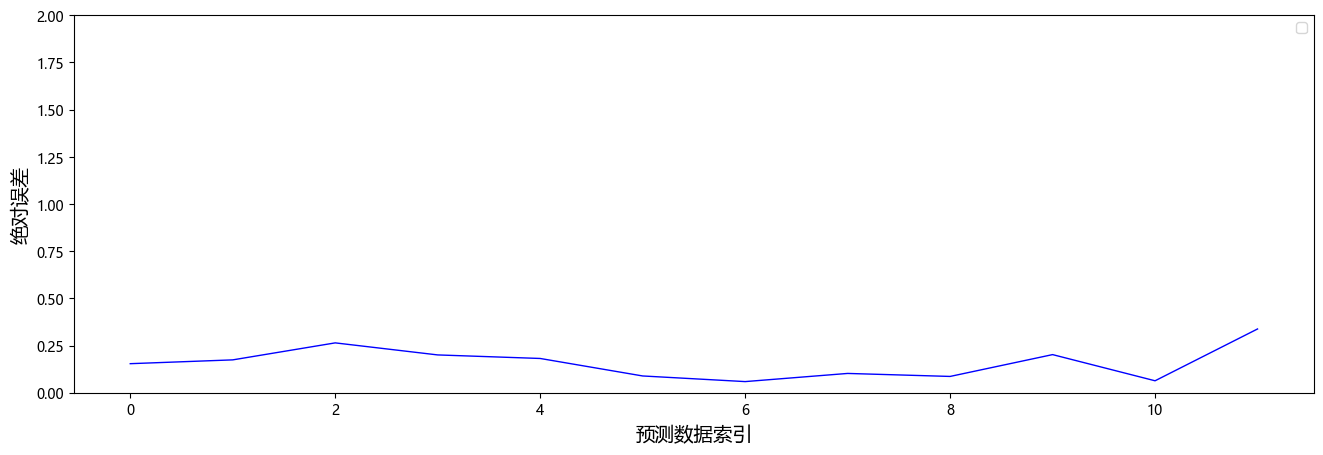

In [59]:
# 求真实值与预测值的误差值
num = len(errors)
plt.figure(figsize=(16,5), dpi=100)
plt.xlabel(u"预测数据索引", fontsize=14)
plt.ylabel(u"绝对误差", fontsize=14)
plt.plot(range(num), errors, c='blue', lw='1')
plt.ylim(0,2)
plt.legend(loc='best')

No handles with labels found to put in legend.


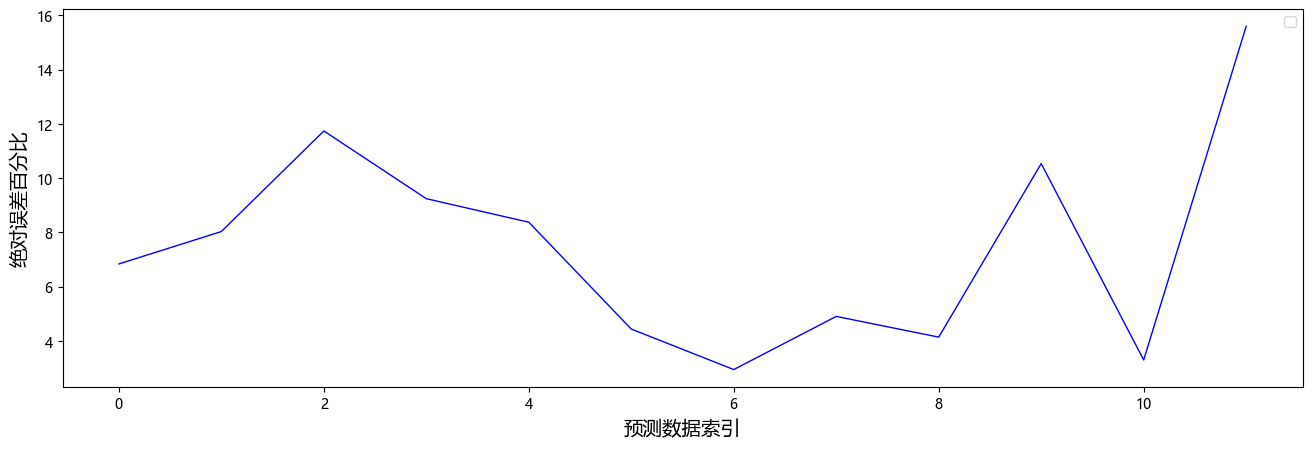

In [60]:
# 求真实值与预测值的误差值占原真实值的百分比
plt.figure(figsize=(16,5), dpi=100)
plt.xlabel(u"预测数据索引", fontsize=14)
plt.ylabel(u"绝对误差百分比", fontsize=14)
plt.plot(range(num), MAPEs, c='blue', lw='1')
plt.legend(loc='best')

### 验证训练集

In [61]:
outputs = model_lstm2(train_X2)
loss = criterion(outputs, train_Y)
loss

tensor(0.0018, grad_fn=<MseLossBackward>)

In [62]:
predict2 = outputs*(max_value-min_value) + min_value
truth2 =  torch.Tensor(train_truth.values.reshape(-1, 1, 12))

In [63]:
print(f"训练集整体MSE: {criterion(predict2, truth2)}")

训练集整体MSE: 0.08554327487945557


In [64]:
print(f"训练集整体MAPE: {mape(truth2, predict2)}")

训练集整体MAPE: 7.44131570255635


In [65]:
# # 还原归一化
# pre = predict[0][0].detach().numpy().tolist()
# tru = train_data.iloc[0, :].values.tolist()
# plt.figure(figsize=(16,5), dpi=100)
# plt.xlabel(u"预测数据索引", fontsize=14)
# plt.ylabel(u"主机CPU平均负载", fontsize=14)
# plt.plot(range(672, 672+12), pre, c='red', lw='1',label="预测值")
# plt.plot(range(672+12), tru, c='blue', lw='1',label="真实值")
# plt.legend(loc='best')

In [66]:
# MSE, MAPE, MAPEs, errors = com_test(pre, tru[-12:])
# print(f"MSE:   {round(MSE, 4)}\nMAPE:  {round(MAPE, 2)}%")

In [67]:
# # 求真实值与预测值的误差值
# errors = []
# for i in range(num):
#     error = abs(truth[i] - predict[i])
#     errors.append(error)
# plt.figure(figsize=(16,5), dpi=100)
# plt.xlabel(u"预测数据索引", fontsize=14)
# plt.ylabel(u"绝对误差", fontsize=14)
# plt.plot(range(num), errors, c='blue', lw='1')
# plt.ylim(0,3)
# plt.legend(loc='best')

In [68]:
# # 求真实值与预测值的误差值占原真实值的百分比
# errors_p = []
# for i in range(num):
#     error = ((abs(truth[i] - predict[i]))/truth[i])*100
#     errors_p.append(error)
# plt.figure(figsize=(16,5), dpi=100)
# plt.xlabel(u"预测数据索引", fontsize=14)
# plt.ylabel(u"绝对误差百分比", fontsize=14)
# plt.plot(range(num), errors_p, c='blue', lw='1')
# plt.ylim(0,70)
# plt.legend(loc='best')

In [69]:
# mean(errors_p)